In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np

from music21 import midi
from music21 import note, stream, duration
from music21 import converter

from models.MuseGAN import MuseGAN

from utils.loaders import load_music

from keras.models import load_model

Using TensorFlow backend.


In [2]:
from music21 import *

In [3]:
us = environment.Environment()
us['musicxmlPath'] = "/usr/bin/mscore"
us['musescoreDirectPNGPath'] = "/usr/bin/mscore"
us['graphicsPath'] = "/usr/bin/mscore"


In [4]:
# run params
SECTION = 'compose'
RUN_ID = '0018'
DATA_NAME = 'chorales'
FILENAME = 'Jsb16thSeparated.npz'
RUN_FOLDER = 'run/{}/'.format(SECTION)
RUN_FOLDER += '_'.join([RUN_ID, DATA_NAME])


## data

In [5]:
BATCH_SIZE = 64
n_bars = 2
n_steps_per_bar = 16
n_pitches = 84
n_tracks = 4

data_binary, data_ints, raw_data = load_music(DATA_NAME, FILENAME, n_bars, n_steps_per_bar)
# data_binary = np.squeeze(data_binary)

In [ ]:
gan = MuseGAN(input_dim = data_binary.shape[1:]
        , critic_learning_rate = 0.001
        , generator_learning_rate = 0.001
        , optimiser = 'adam'
        , grad_weight = 10
        , z_dim = 32
        , batch_size = BATCH_SIZE
        , n_tracks = n_tracks
        , n_bars = n_bars
        , n_steps_per_bar = n_steps_per_bar
        , n_pitches = n_pitches
        )



W1122 21:42:38.561647 139620787275584 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1122 21:42:38.577229 139620787275584 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1122 21:42:38.578116 139620787275584 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4115: The name tf.random_normal is deprecated. Please use tf.random.normal instead.

W1122 21:42:38.728934 139620787275584 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W1122 21:42:38.729585 139620787275

In [3]:
gan.load_weights(RUN_FOLDER, None)

NameError: name 'gan' is not defined

In [8]:
gan.generator.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
melody_input (InputLayer)       (None, 4, 32)        0                                            
__________________________________________________________________________________________________
chords_input (InputLayer)       (None, 32)           0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 32)           0           melody_input[0][0]               
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 32)           0           melody_input[0][0]               
__________________________________________________________________________________________________
lambda_3 (

In [9]:
gan.critic.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
critic_input (InputLayer)    (None, 2, 16, 84, 4)      0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 1, 16, 84, 128)    1152      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 1, 16, 84, 128)    0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 1, 16, 84, 128)    16512     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 1, 16, 84, 128)    0         
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 1, 16, 7, 128)     196736    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 1, 16, 7, 128)     0         
__________

# view sample score

In [10]:
chords_noise = np.random.normal(0, 1, (1, gan.z_dim))
style_noise = np.random.normal(0, 1, (1, gan.z_dim))
melody_noise = np.random.normal(0, 1, (1, gan.n_tracks, gan.z_dim))
groove_noise = np.random.normal(0, 1, (1, gan.n_tracks, gan.z_dim))

In [11]:
gen_scores = gan.generator.predict([chords_noise, style_noise, melody_noise, groove_noise])

In [12]:
np.argmax(gen_scores[0,0,0:4,:,3], axis = 1)

array([52, 52, 47, 47])

In [13]:
gen_scores[0,0,0:4,60,3] = 0.02347812

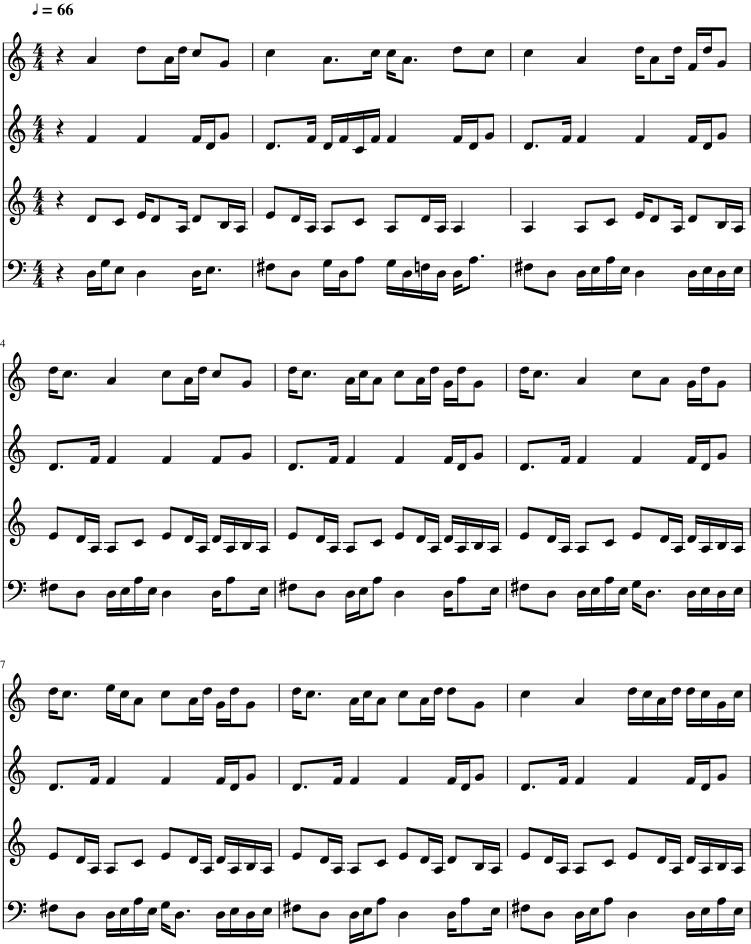

In [8]:
filename = '0'
# gan.notes_to_midi(RUN_FOLDER, gen_scores, filename)
gen_score = converter.parse(os.path.join(RUN_FOLDER, 'samples/{}.midi'.format(filename)))
gen_score.show()

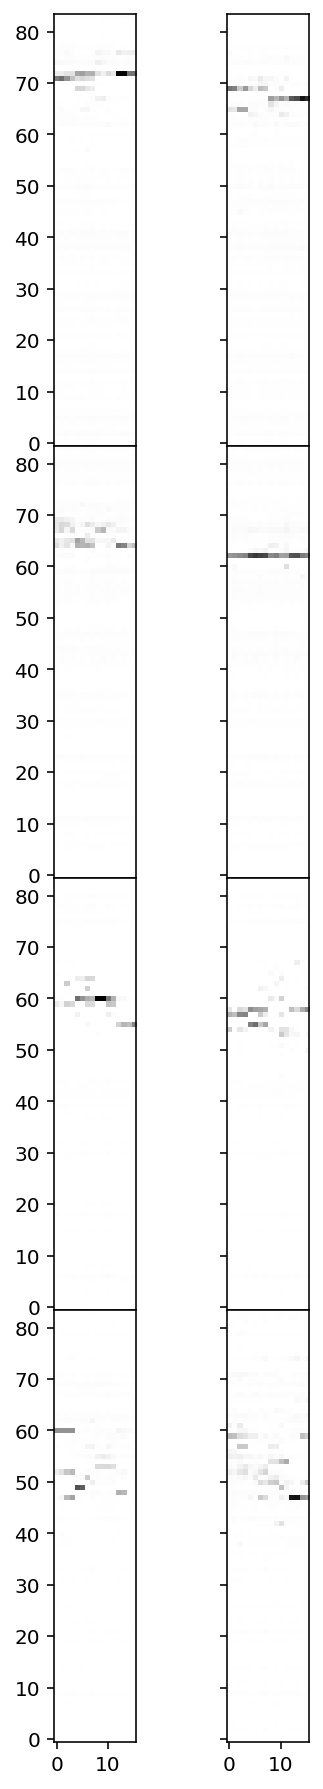

In [15]:
gan.draw_score(gen_scores, 0)

# find the closest match

In [16]:
def find_closest(data_binary, score):
    current_dist = 99999999
    current_i = -1
    for i, d in enumerate(data_binary):
        dist = np.sqrt(np.sum(pow((d - score),2)))
        if dist < current_dist:
            current_i = i
            current_dist = dist
        
    return current_i
    

In [17]:
closest_idx = find_closest(data_binary, gen_scores[0])
closest_data = data_binary[[closest_idx]]
print(closest_idx)

52


In [9]:
filename = 'closest'
gan.notes_to_midi(RUN_FOLDER, closest_data,filename)
closest_score = converter.parse(os.path.join(RUN_FOLDER, 'samples/{}.midi'.format(filename)))
print('original')
gen_score.show()
print('closest')
closest_score.show()


NameError: name 'gan' is not defined

# changing the chords noise

In [19]:
chords_noise_2 = 5 * np.ones((1, gan.z_dim))

In [20]:
chords_scores = gan.generator.predict([chords_noise_2, style_noise, melody_noise, groove_noise])

original


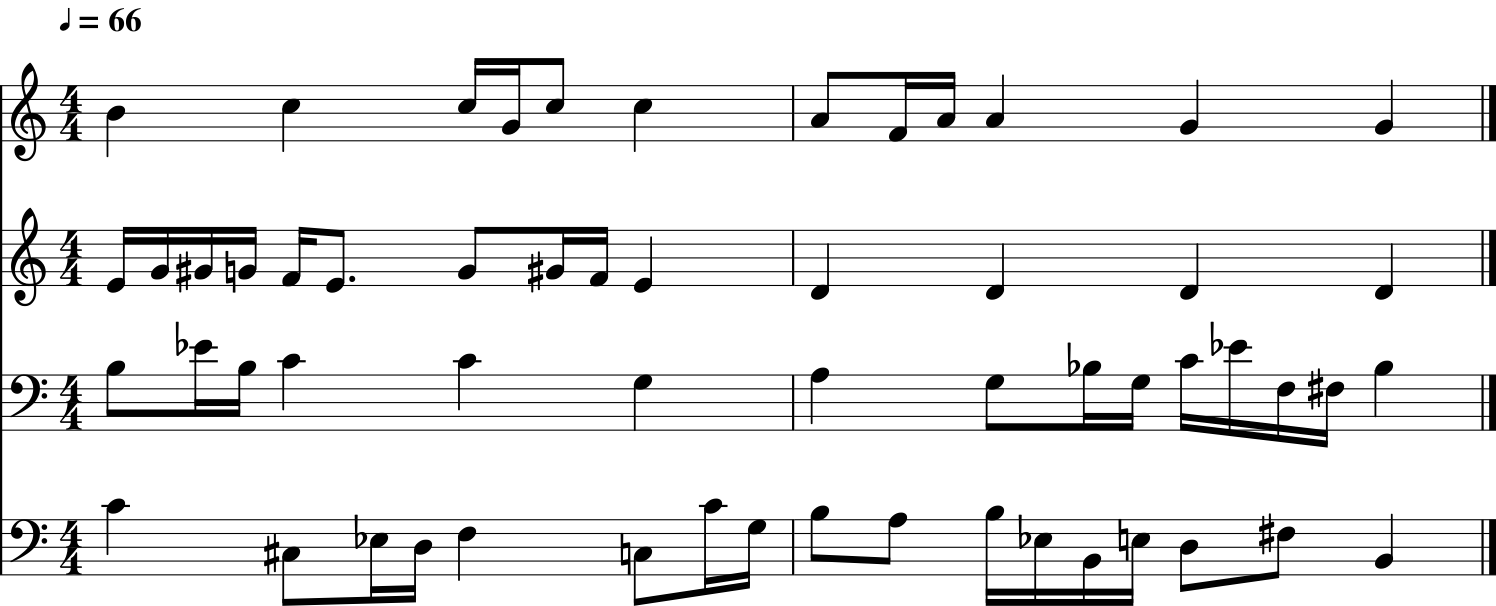

chords noise changed


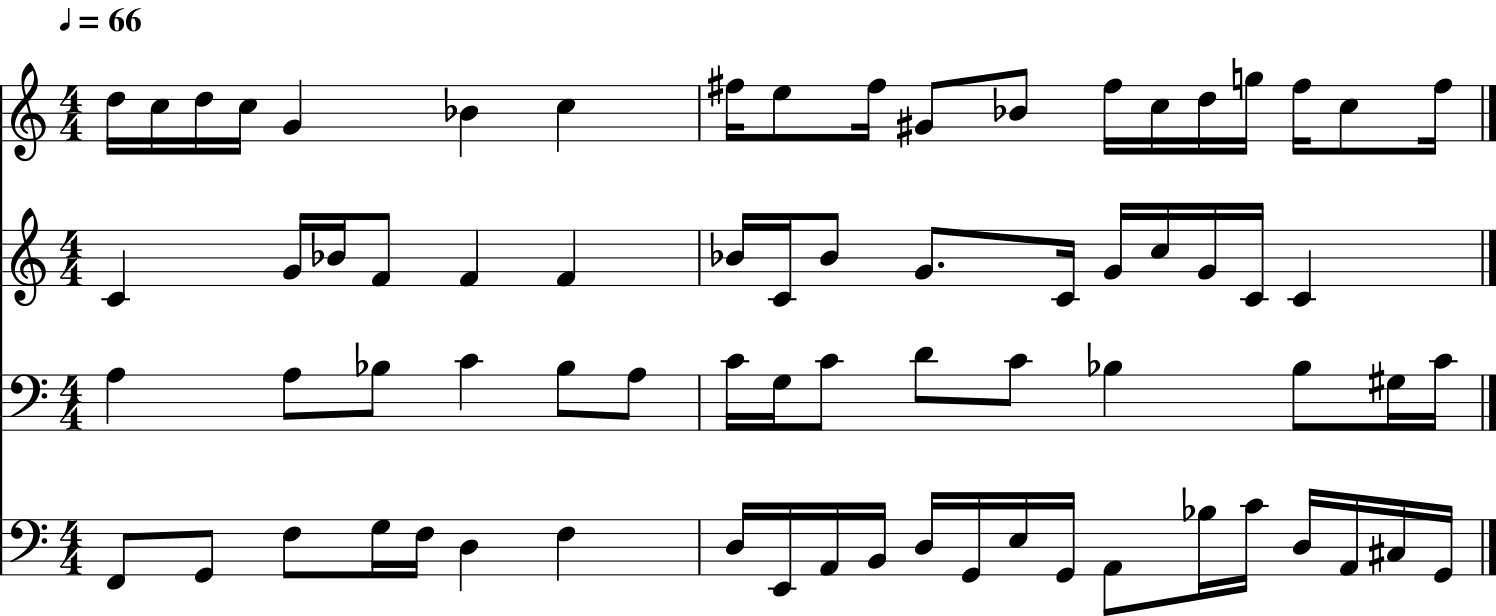

In [21]:
filename = 'changing_chords'
gan.notes_to_midi(RUN_FOLDER, chords_scores, filename)
chords_score = converter.parse(os.path.join(RUN_FOLDER, 'samples/{}.midi'.format(filename)))
print('original')
gen_score.show()
print('chords noise changed')
chords_score.show()

# changing the style noise

In [22]:
style_noise_2 = 5 * np.ones((1, gan.z_dim))

In [23]:
style_scores = gan.generator.predict([chords_noise, style_noise_2, melody_noise, groove_noise])

original


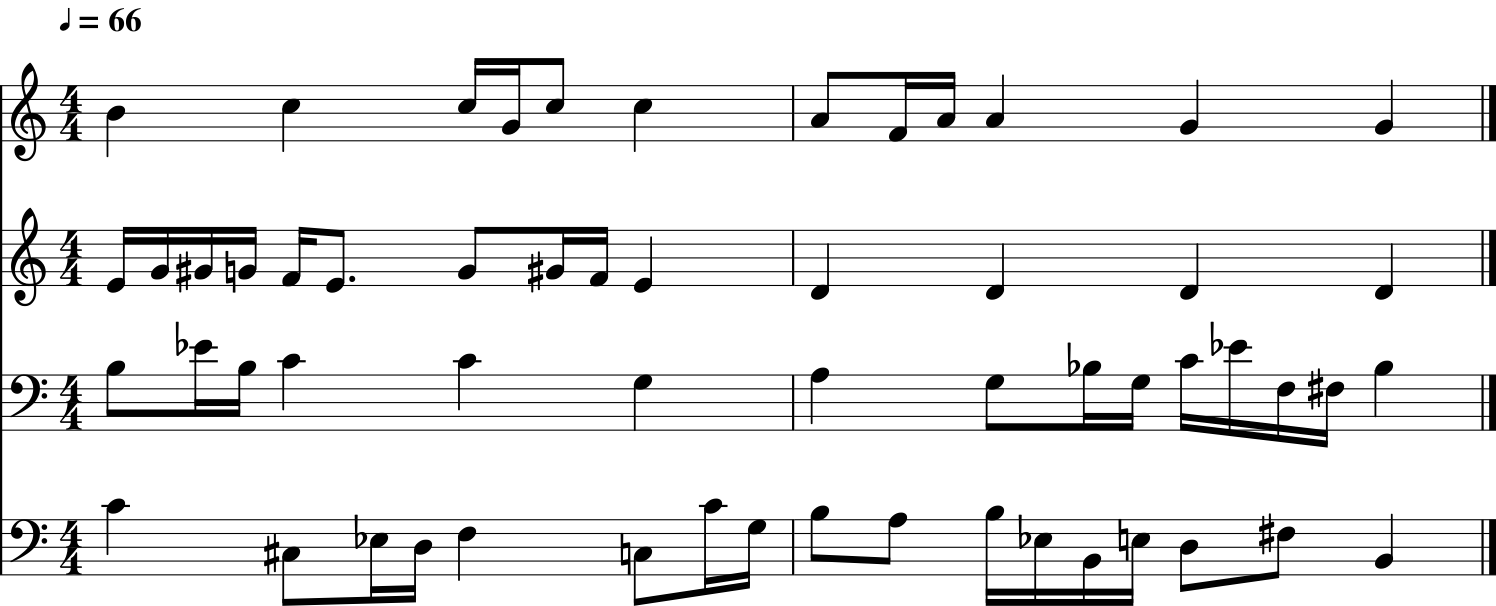

style noise changed


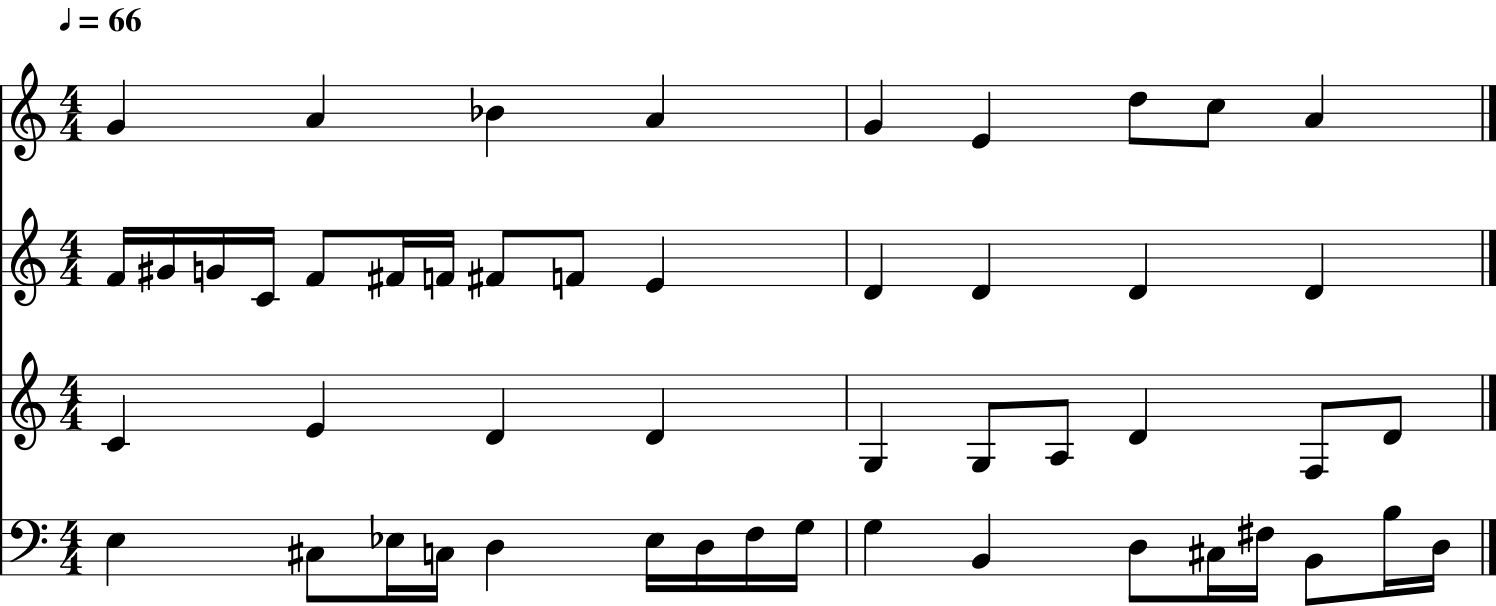

In [24]:
filename = 'changing_style'
gan.notes_to_midi(RUN_FOLDER, style_scores, filename)
style_score = converter.parse(os.path.join(RUN_FOLDER, 'samples/{}.midi'.format(filename)))
print('original')
gen_score.show()
print('style noise changed')
style_score.show()

# changing the melody noise

In [25]:
melody_noise_2 = np.copy(melody_noise)
melody_noise_2[0,0,:] = 5 * np.ones(gan.z_dim) 

In [26]:
melody_scores = gan.generator.predict([chords_noise, style_noise, melody_noise_2, groove_noise])

original


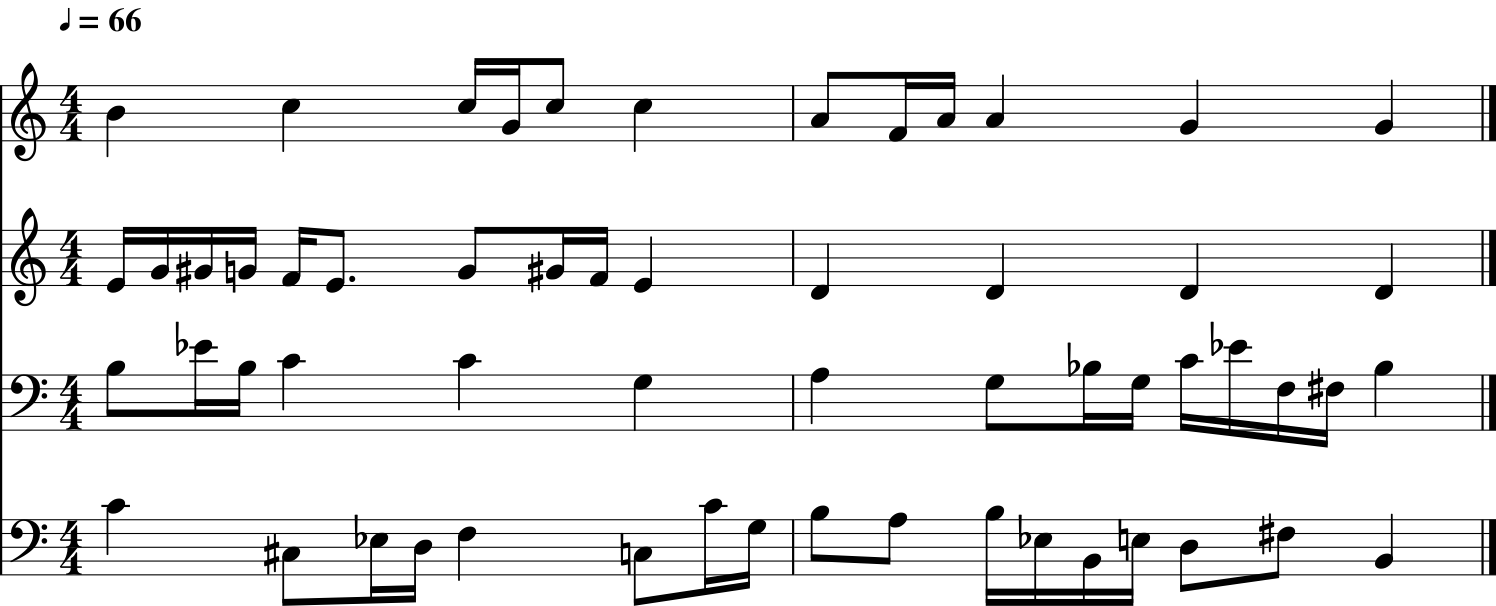

melody noise changed


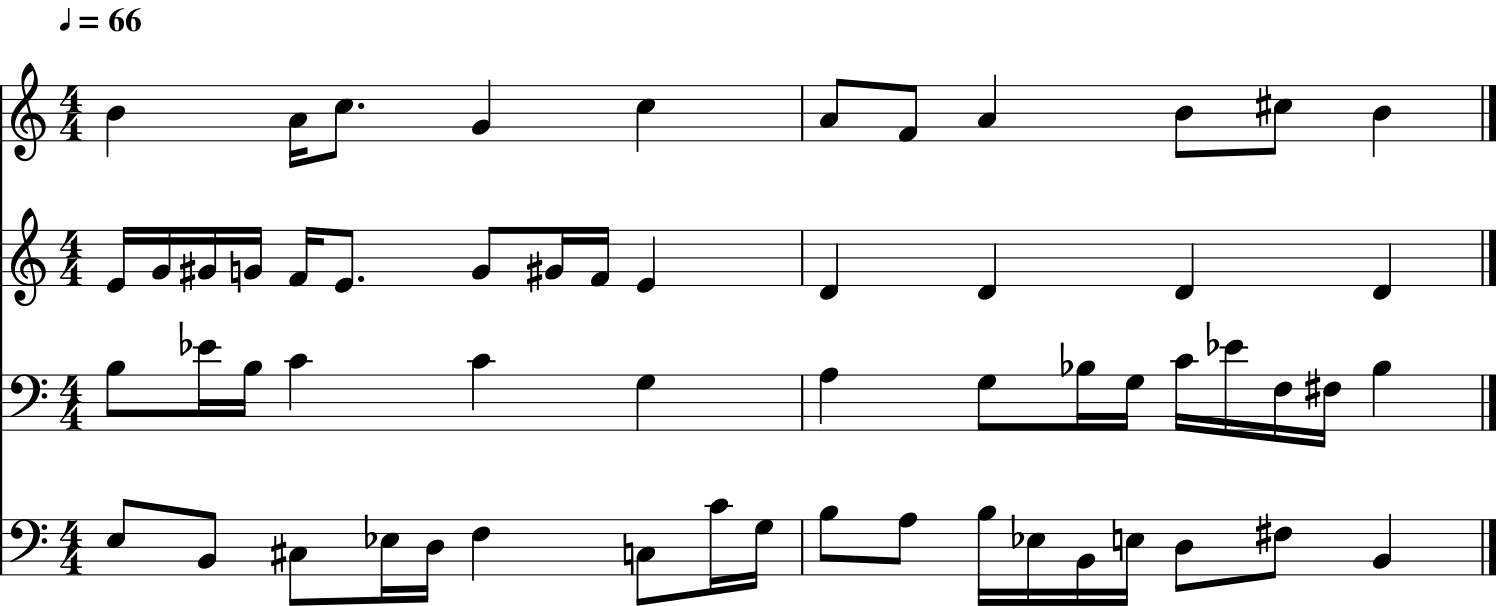

In [27]:
filename = 'changing_melody'
gan.notes_to_midi(RUN_FOLDER, melody_scores, filename)
melody_score = converter.parse(os.path.join(RUN_FOLDER, 'samples/{}.midi'.format(filename)))
print('original')
gen_score.show()
print('melody noise changed')
melody_score.show()

# changing the groove noise

In [28]:
groove_noise_2 = np.copy(groove_noise)
groove_noise_2[0,3,:] = 5 * np.ones(gan.z_dim)

In [29]:
groove_scores = gan.generator.predict([chords_noise, style_noise, melody_noise, groove_noise_2])

original


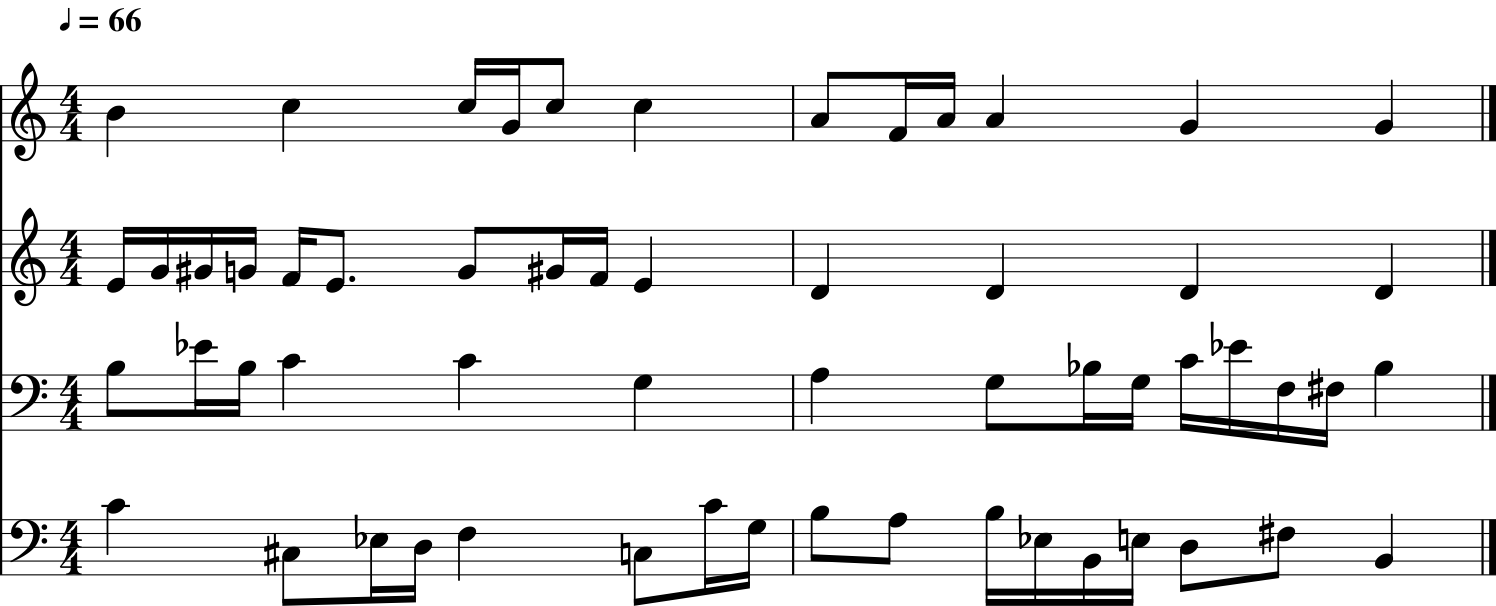

groove noise changed


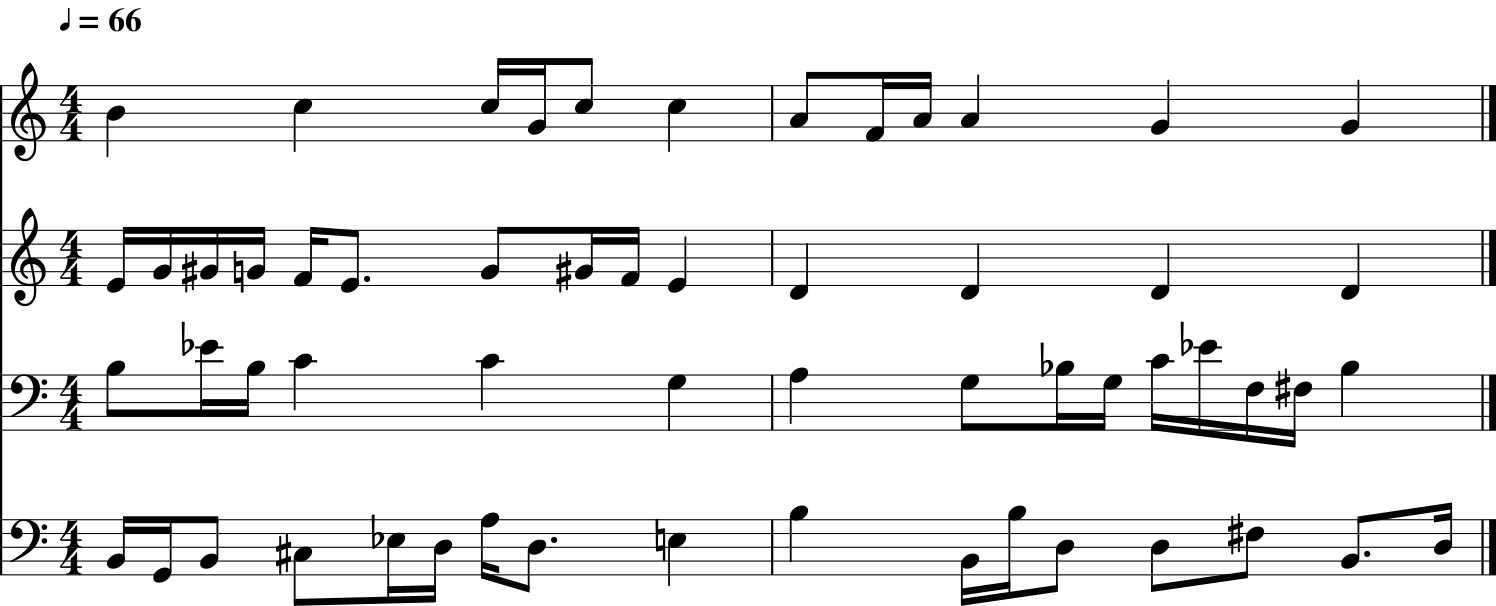

In [30]:
filename = 'changing_groove'
gan.notes_to_midi(RUN_FOLDER, groove_scores, filename)
groove_score = converter.parse(os.path.join(RUN_FOLDER, 'samples/{}.midi'.format(filename)))
print('original')
gen_score.show()
print('groove noise changed')
groove_score.show()